In [40]:
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_moons

In [41]:
# --- Data Generation ---
np.random.seed(42)
n_samples = 2000
means = np.array([[-1, -1], [1, 1]])
covariances = [np.array([[1, 0.5], [0.5, 1]]), np.array([[1, -0.5], [-0.5, 1]])]
proportions = [0.5, 0.5]
n_clusters = len(means)

# Generate data
data = []
labels = []
for i, (mean, cov, prop) in enumerate(zip(means, covariances, proportions)):
    n = int(prop * n_samples)
    cluster_data = np.random.multivariate_normal(mean, cov, n)
    data.append(cluster_data)
    labels += [i] * n
data = np.vstack(data)
labels = np.array(labels)

In [42]:
# --- Plotting Utility ---
def plot_clusters(data, labels, centroids=None, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    if labels.ndim > 1:
        c=  labels[:,0]
    else:
        c = labels
    ax.scatter(data[:, 0], data[:, 1], c=c, cmap="coolwarm", s=10)
    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], s=300, c="black", marker="X")
    if title is not None:
        ax.set_title(title)

def plot_gaussian_ellipses(means, covariances, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for mean, cov in zip(means, covariances):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(
            xy=mean,
            width=width,
            height=height,
            angle=angle,
            edgecolor="black",
            fc="None",
            lw=2,
        )
        ax.add_patch(ellipse)

In [43]:
# --- KMeans Class ---
class KMeansCustom:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def initialize_centroids(self, data):
        n_samples = data.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = data[indices]

    def assign_clusters(self, data):
        """
        Assign each point to the nearest centroid.
        """
        # TODO:  # Fill in this method
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def update_centroids(self, data, labels):
        """
        Update centroids as the mean of all points assigned to each cluster.
        """
        # TODO:  # Fill in this method
        new_centroids = np.zeros_like(self.centroids)

        for k in range(self.n_clusters):
            # Select all points assigned to cluster k
            cluster_points = data[labels == k]

            if len(cluster_points) > 0:
                # Update centroid as the mean of assigned points
                new_centroids[k] = cluster_points.mean(axis=0)
            else:
                # If no points are assigned to the centroid, reinitialize it randomly
                new_centroids[k] = data[np.random.choice(data.shape[0])]

        return new_centroids

    def fit(self, data, iterations_to_store=[0, 1, 2, 5, 10, 20]):
        self.initialize_centroids(data)
        self.stored_params = {}
        for i in range(max(iterations_to_store) + 1):
            labels = self.assign_clusters(data)
            new_centroids = self.update_centroids(data, labels)
            if i in iterations_to_store:
                self.stored_params[i] = {
                    "centroids": self.centroids.copy(),
                    "labels": labels.copy(),
                }
            self.centroids = new_centroids

    def predict(self, data):
        return self.assign_clusters(data)

In [44]:
# --- EM Class ---
class EMGMM:
    def __init__(self, n_components):
        self.n_components = n_components

    def initialize_params(self, data):
        n_samples, n_features = data.shape
        self.means = data[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.eye(n_features)] * self.n_components)
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, data):
        """
        Compute responsibilities (soft assignments) for each cluster.
        """
        # TODO:  Fill in this method
        n_samples = data.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            pdf = self.multivariate_gaussian(data, self.means[k], self.covariances[k])
            responsibilities[:, k] = self.weights[k] * pdf

        # Normalize the responsibilities across all components
        sum_responsibilities = np.sum(responsibilities, axis=1, keepdims=True)
        # Avoid division by zero
        sum_responsibilities[sum_responsibilities == 0] = 1e-10
        responsibilities /= sum_responsibilities

        return responsibilities

    def m_step(self, data, responsibilities):
        """
        Update means, covariances, and weights based on responsibilities.
        """
        # TODO:  Fill in this method
        n_samples, n_features = data.shape

        # Compute N_k for each component
        N_k = responsibilities.sum(axis=0)  # Shape: (n_components,)

        # Update means
        self.means = (responsibilities.T @ data) / N_k[:, np.newaxis]  # Shape: (n_components, n_features)

        # Update covariances
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            diff = data - self.means[k]  # Shape: (n_samples, n_features)
            weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
            self.covariances[k] = (weighted_diff.T @ diff) / N_k[k]
            # Add a small value to the diagonal for numerical stability
            self.covariances[k] += 1e-6 * np.eye(n_features)

        # Update weights
        self.weights = N_k / n_samples  # Shape: (n_components,)

    def multivariate_gaussian(self, data, mean, cov):
        """
        Compute the multivariate Gaussian probability density.
        """
        # pass # Fill in this method
        n_features = data.shape[1]
        cov_det = np.linalg.det(cov)
        cov_inv = np.linalg.inv(cov)
        norm_factor = 1 / np.sqrt((2 * np.pi) ** n_features * cov_det)
        diff = data - mean
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        pdf = norm_factor * np.exp(exponent)
        return pdf

    def fit(self, data, iterations_to_store=[0, 1, 2, 5, 10, 20]):
        self.initialize_params(data)
        self.stored_params = {}
        for i in range(max(iterations_to_store) + 1):
            responsibilities = self.e_step(data)
            self.m_step(data, responsibilities)
            if i in iterations_to_store:
                self.stored_params[i] = {
                    "means": self.means.copy(),
                    "covariances": self.covariances.copy(),
                    "responsibilities": responsibilities.copy(),
                }
                #hard_labels = np.argmax(responsibilities, axis=1)
                #fig, ax = plt.subplots(figsize=(8, 6))
                #plot_clusters(data, hard_labels, centroids=self.means, title=f'EM GMM at Iteration {i}', ax=ax)
                #plot_gaussian_ellipses(self.means, self.covariances, ax=ax)
                #plt.show()

    def predict(self, data):
        responsibilities = self.e_step(data)
        return np.argmax(responsibilities, axis=1)

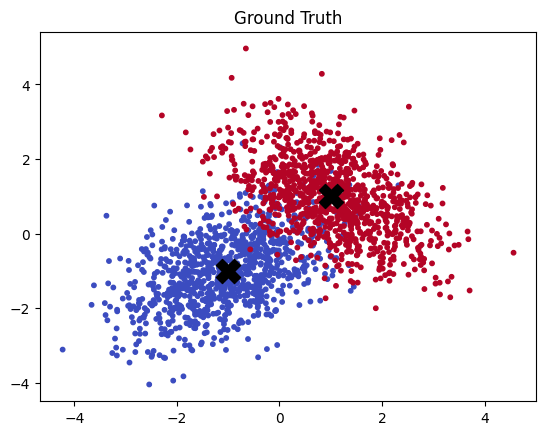

In [45]:
# --- Example Usage ---
# Plot initial data
plot_clusters(data, labels, means, title="Ground Truth")

In [46]:
# Run k-means
kmeans = KMeansCustom(n_clusters=n_clusters)
kmeans.fit(data)
kmeans_labels = kmeans.predict(data)

# Metrics
ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
print(f"k-means ARI: {ari_kmeans:.3f}")

k-means ARI: 0.704


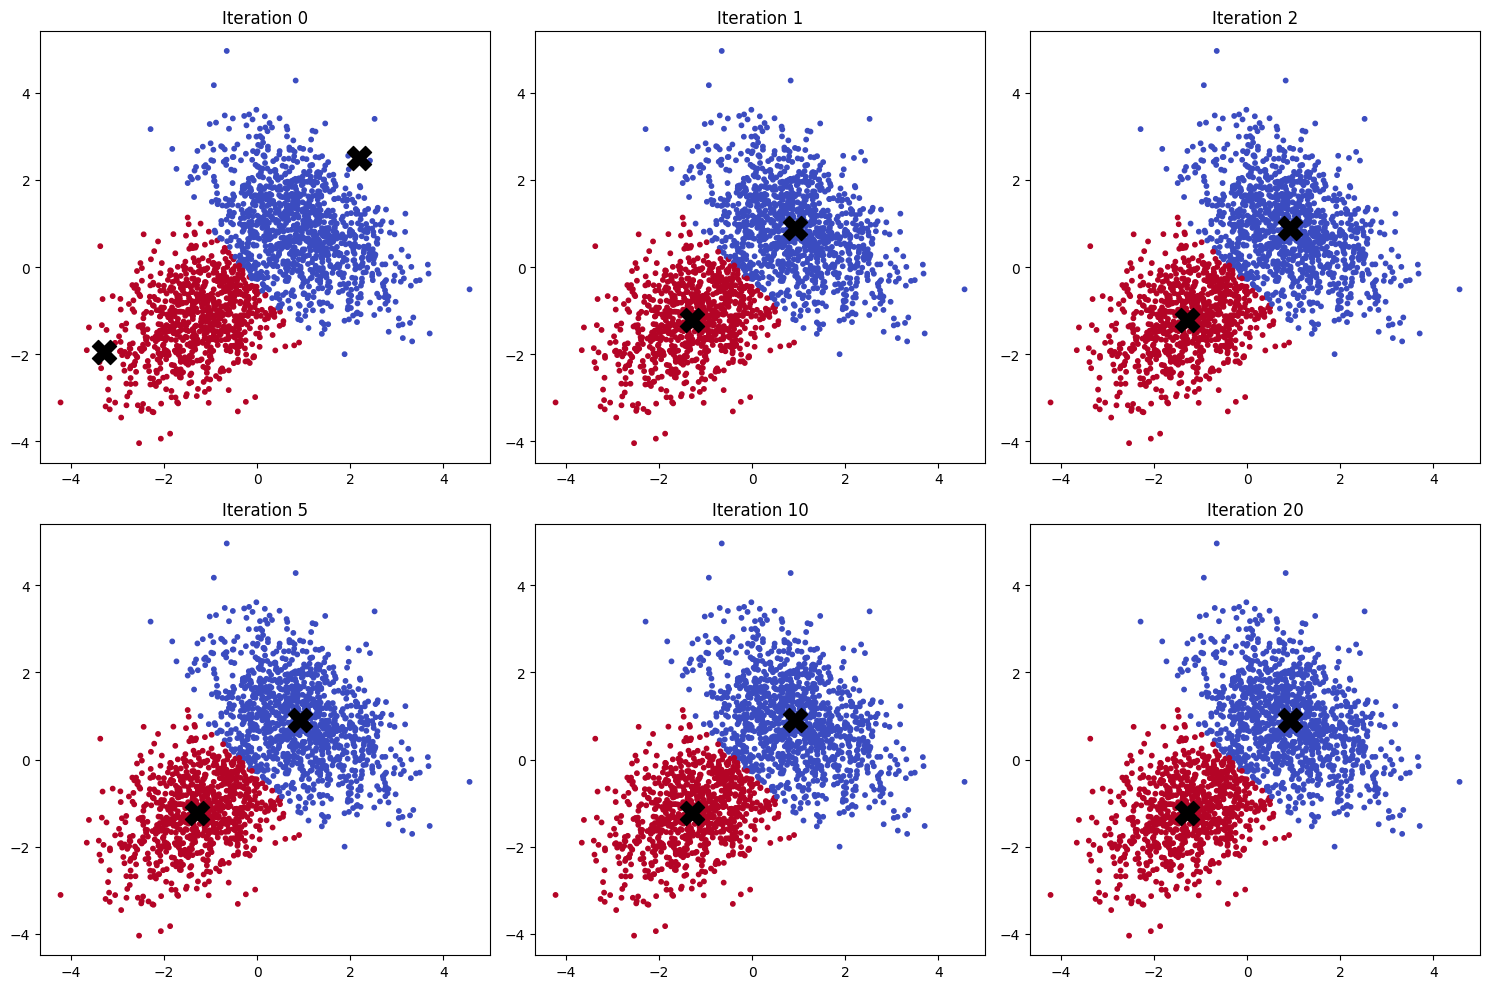

In [47]:
iterations = [0, 1, 2, 5, 10, 20]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = kmeans.stored_params[i]["labels"]
    em_centroids = kmeans.stored_params[i]["centroids"]
    plot_clusters(data, responsibilities, em_centroids, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()

In [48]:
# Run EM
em = EMGMM(n_components=n_clusters)
em.fit(data)
em_labels = em.predict(data)

# Metrics
ari_em = adjusted_rand_score(labels, em_labels)
print(f"EM ARI: {ari_em:.3f}")

EM ARI: 0.771


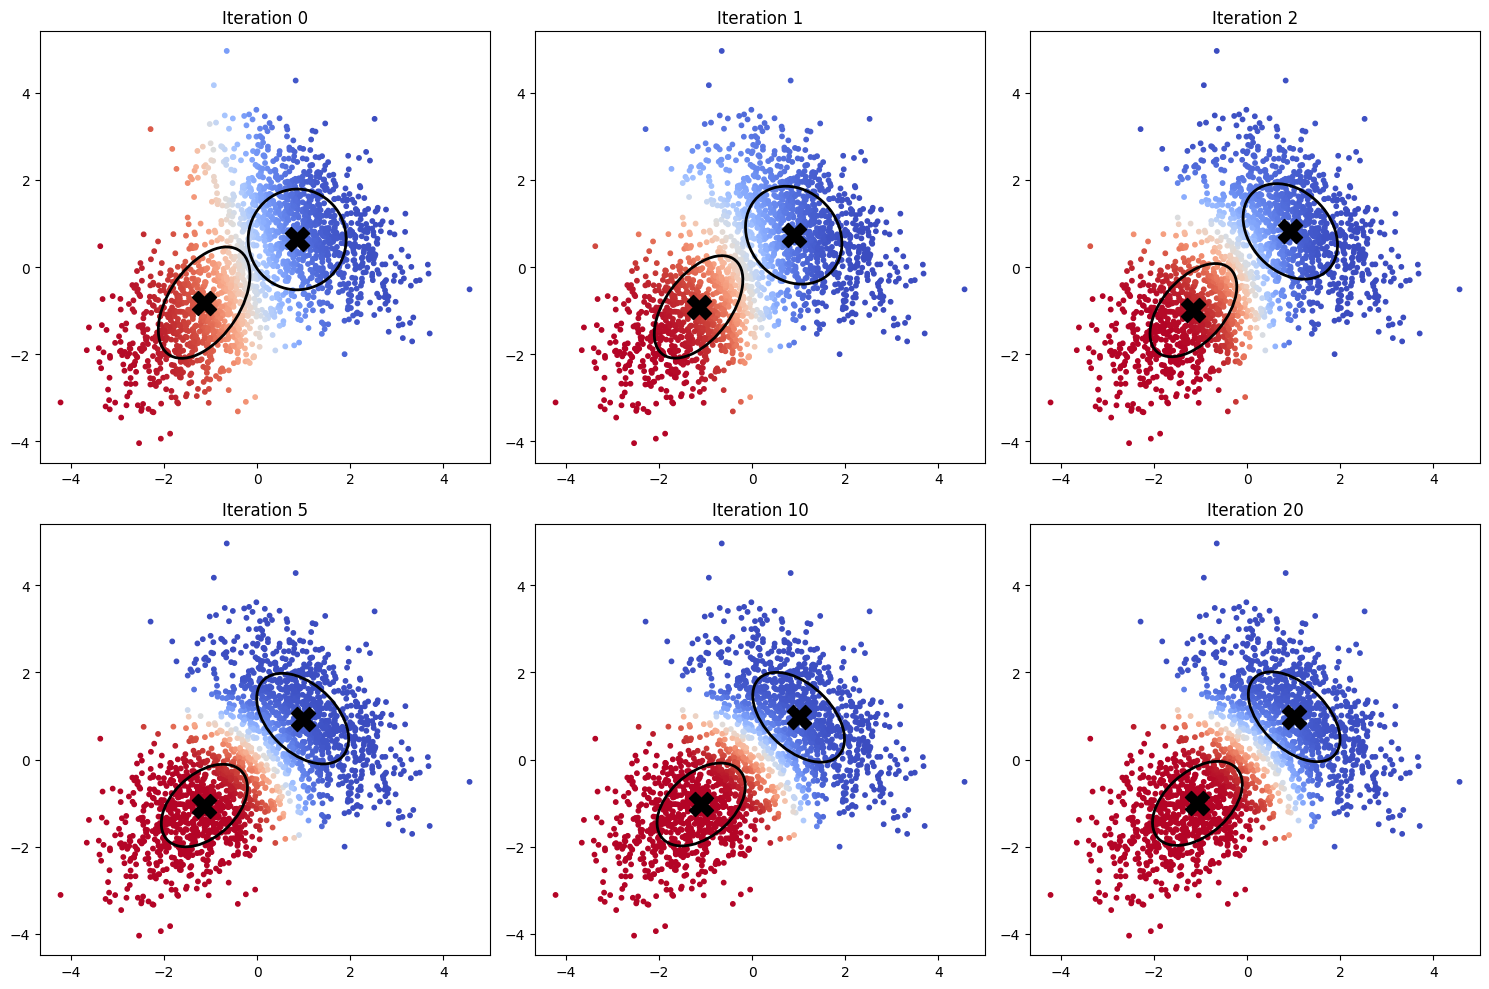

In [49]:
iterations = [0, 1, 2, 5, 10, 20]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = em.stored_params[i]["responsibilities"]
    cov = em.stored_params[i]["covariances"]
    em_centroids = em.stored_params[i]["means"]
    plot_clusters(data, responsibilities, em_centroids, ax=ax)
    plot_gaussian_ellipses(em_centroids, cov, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()


=== Running k-Means with k=2 ===
ARI for k-Means with k=2: 0.7038

=== Running EM GMM with k=2 ===
ARI for EM GMM with k=2: 0.7725


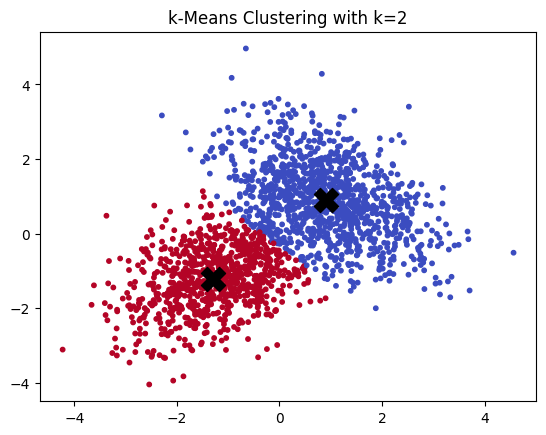

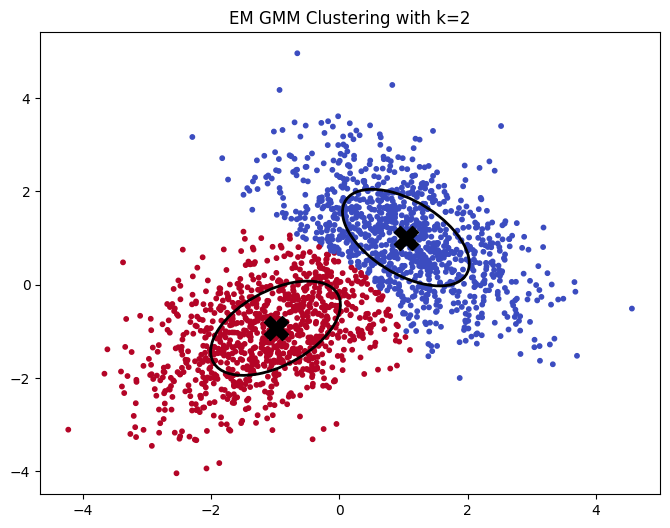


=== Running k-Means with k=4 ===
ARI for k-Means with k=4: 0.3828

=== Running EM GMM with k=4 ===
ARI for EM GMM with k=4: 0.5253


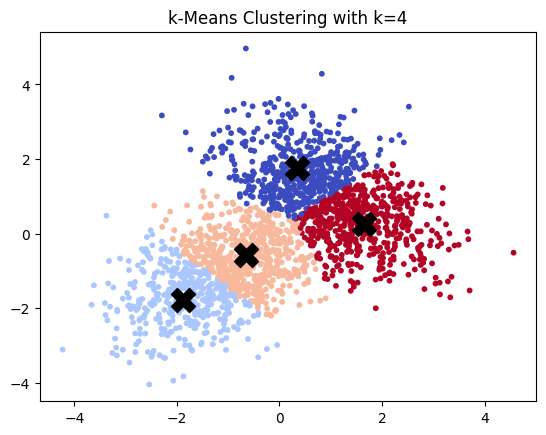

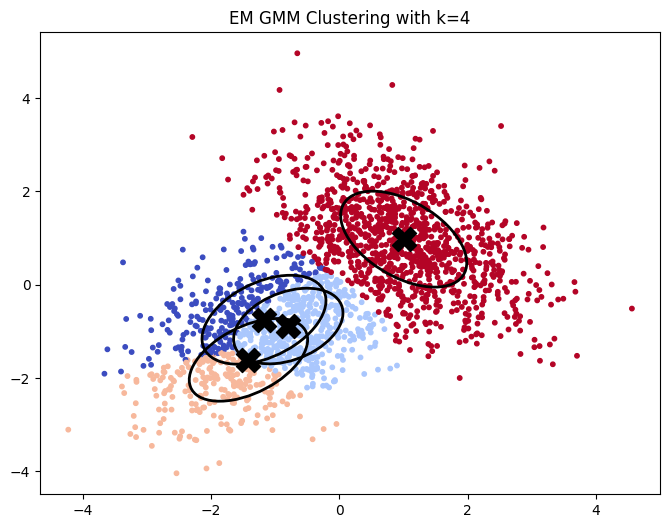


=== Running k-Means with k=8 ===
ARI for k-Means with k=8: 0.2289

=== Running EM GMM with k=8 ===
ARI for EM GMM with k=8: 0.2782


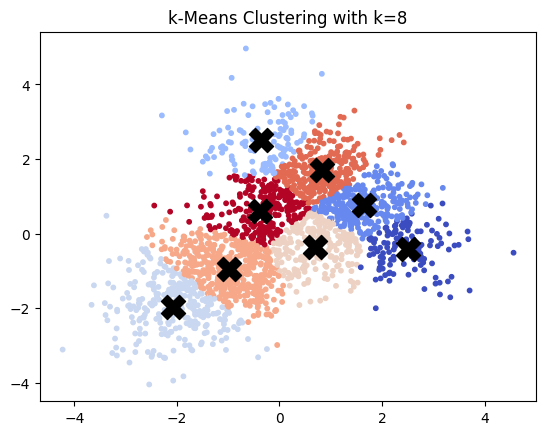

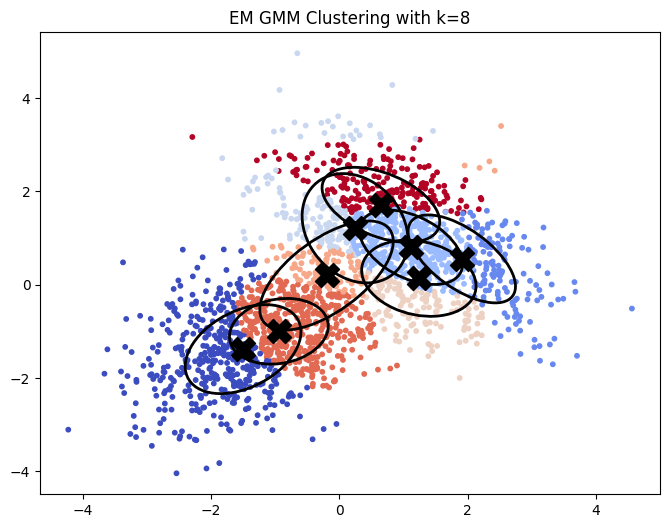

In [50]:
# --- Q5: The Effect of Overestimating Clusters ---

# TODO: # Fill in the code to run k-means and EM with different values of k and plot the results and ARI scores.
k_values = [2, 4, 8]

# Initialize lists to store ARI scores
ari_kmeans_scores = []
ari_em_scores = []

for k in k_values:
    print(f'\n=== Running k-Means with k={k} ===')
    # Instantiate and fit KMeansCustom
    kmeans = KMeansCustom(n_clusters=k)
    kmeans.fit(data, iterations_to_store=[0, 1, 2, 5, 10, 20])
    # Predict final labels
    final_labels_kmeans = kmeans.predict(data)
    # Compute ARI for k-Means
    ari_kmeans = adjusted_rand_score(labels, final_labels_kmeans)
    ari_kmeans_scores.append(ari_kmeans)
    print(f'ARI for k-Means with k={k}: {ari_kmeans:.4f}')

    plot_clusters(
        data,
        final_labels_kmeans,
        centroids=kmeans.centroids,
        title=f'k-Means Clustering with k={k}'
    )

    print(f'\n=== Running EM GMM with k={k} ===')
    # Instantiate and fit EMGMM
    em_gmm = EMGMM(n_components=k)
    em_gmm.fit(data, iterations_to_store=[0, 1, 2, 5, 10, 20])
    # Predict final labels
    final_labels_em = em_gmm.predict(data)
    # Compute ARI for EM GMM
    ari_em = adjusted_rand_score(labels, final_labels_em)
    ari_em_scores.append(ari_em)
    print(f'ARI for EM GMM with k={k}: {ari_em:.4f}')

    fig, ax = plt.subplots(figsize=(8, 6))
    plot_clusters(
        data,
        final_labels_em,
        centroids=em_gmm.means,
        title=f'EM GMM Clustering with k={k}',
        ax=ax
    )
    plot_gaussian_ellipses(
        em_gmm.means,
        em_gmm.covariances,
        ax=ax
    )
    plt.show()




=== Running k-Means with k=2 ===
ARI for k-Means with k=2: 0.2427

=== Running EM GMM with k=2 ===
ARI for EM GMM with k=2: 0.3396


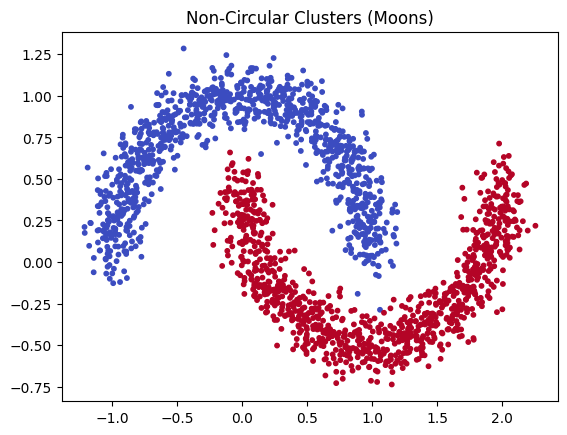

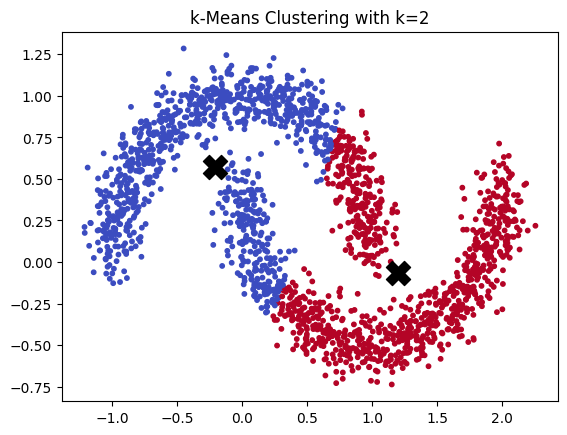

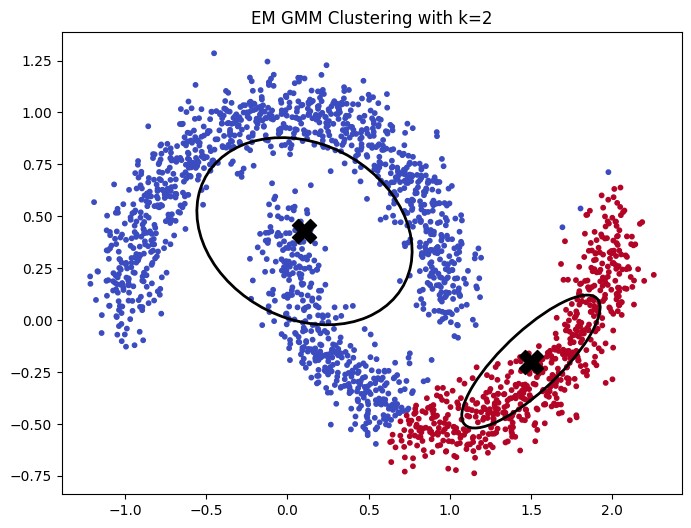


=== Running k-Means with k=4 ===
ARI for k-Means with k=4: 0.2736

=== Running EM GMM with k=4 ===
ARI for EM GMM with k=4: 0.4872


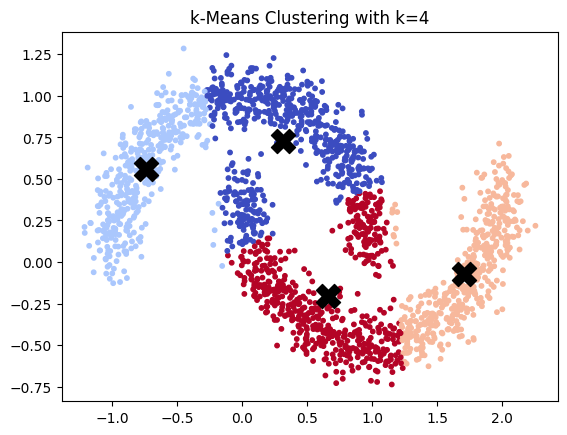

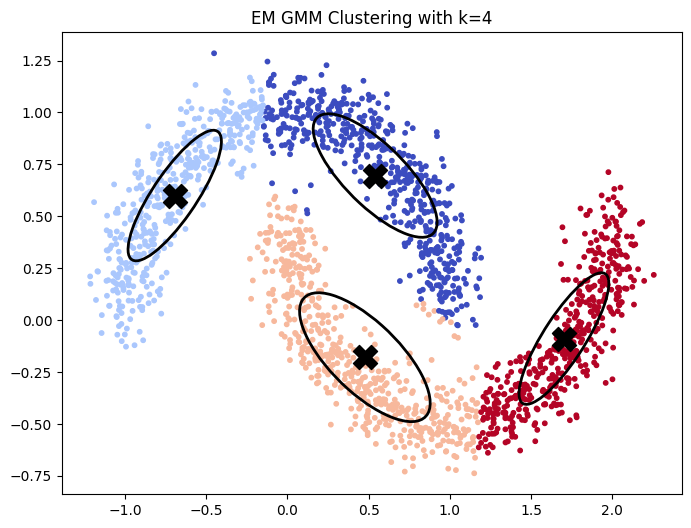

In [51]:
# --- Q6: Non-Circular Clusters (make_moons) ---
def generate_moons_data():
    data, labels = make_moons(n_samples=2000, noise=0.1, random_state=42)
    return data, labels

moons_data, moons_labels = generate_moons_data()
plot_clusters(moons_data, moons_labels, title="Non-Circular Clusters (Moons)")

# TODO: # Fill in the code to run k-means and EM on the moons dataset for k = 2 and 4 clusters and plot the results

# Define the different values of k to test
k_values = [2, 4]

# Initialize lists to store ARI scores
ari_kmeans_scores = []
ari_em_scores = []

# Iterate over each k value
for k in k_values:
    print(f'\n=== Running k-Means with k={k} ===')
    # Instantiate and fit KMeansCustom
    kmeans = KMeansCustom(n_clusters=k)
    kmeans.fit(moons_data, iterations_to_store=[0, 1, 2, 5, 10, 20])
    # Predict final labels
    final_labels_kmeans = kmeans.predict(moons_data)
    # Compute ARI for k-Means
    ari_kmeans = adjusted_rand_score(moons_labels, final_labels_kmeans)
    ari_kmeans_scores.append(ari_kmeans)
    print(f'ARI for k-Means with k={k}: {ari_kmeans:.4f}')

    plot_clusters(
        moons_data,
        final_labels_kmeans,
        centroids=kmeans.centroids,
        title=f'k-Means Clustering with k={k}'
    )

    print(f'\n=== Running EM GMM with k={k} ===')
    # Instantiate and fit EMGMM
    em_gmm = EMGMM(n_components=k)
    em_gmm.fit(moons_data, iterations_to_store=[0, 1, 2, 5, 10, 20])
    # Predict final labels
    final_labels_em = em_gmm.predict(moons_data)
    # Compute ARI for EM GMM
    ari_em = adjusted_rand_score(moons_labels, final_labels_em)
    ari_em_scores.append(ari_em)
    print(f'ARI for EM GMM with k={k}: {ari_em:.4f}')

    fig, ax = plt.subplots(figsize=(8, 6))
    plot_clusters(
        moons_data,
        final_labels_em,
        centroids=em_gmm.means,
        title=f'EM GMM Clustering with k={k}',
        ax=ax
    )
    plot_gaussian_ellipses(
        em_gmm.means,
        em_gmm.covariances,
        ax=ax
    )
    plt.show()



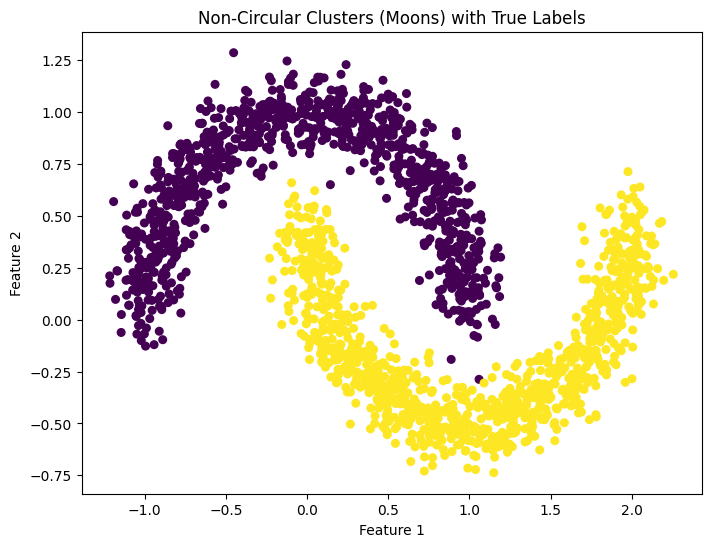

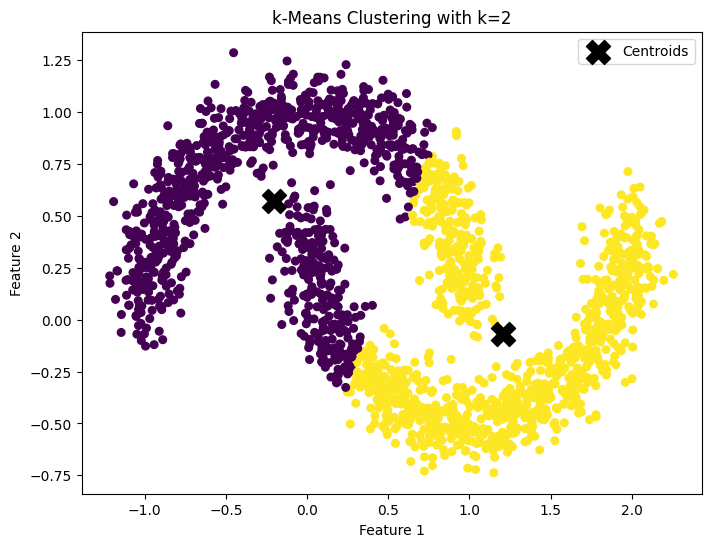

In [52]:
# Just a test

# Generate non-convex moon-shaped clusters
data, true_labels = make_moons(n_samples=2000, noise=0.1, random_state=42)

# Visualize the dataset with true labels
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=true_labels, cmap='viridis', s=30)
plt.title('Non-Circular Clusters (Moons) with True Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Initialize and fit k-Means with k=2
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)
kmeans.fit(data)
kmeans_labels = kmeans.predict(data)

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis', s=30)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=300, c='black', marker='X', label='Centroids')
plt.title('k-Means Clustering with k=2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()